# Correlation

Let's experiment with correlation using fake time series.  We will also take a quick look at interpolation.  In all of the following, the assumption is that arrays contain data sampled uniformly in time or space.  (This can be relaxed when calculating the correlation coefficient at zero lag.)

In [1]:
%matplotlib notebook

# Our standard imports:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Access to many standard distributions:
import scipy.stats as ss

The first thing to do is find out what functions are available, and how to use at least some of them. There are several types of calculation in the category of "correlation".  "Autocorrelation" is the correlation of a time series with a lagged copy of itself.  "Crosscorrelation" is correlation between two series of the same length, with or without lags. "Correlation coefficient" is a normalized correlation.  "Convolution" is a lagged correlation in which the series may differ in length, and in which one of the series is reversed.  There are also variations involving normalization, and the treatment of complex numbers.  The terminology is not entirely standardized, and can differ from one discipline to another. Before you use any given function, check to be sure you know exactly what it is doing. I suggest that you take a look at 

- http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html#numpy.corrcoef
- http://docs.scipy.org/doc/numpy/reference/generated/numpy.ma.corrcoef.html#numpy.ma.corrcoef (for masked arrays)
- http://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html#numpy.correlate
- http://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html#numpy.convolve
- http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve

Notice that only one of these handles masked arrays; it calculates the correlation coefficients with zero lag.  For anything else, if you have masked arrays or NaNs, you need to write your own code to handle the missing points appropriately.  Unless you are calculating a zero-lag correlation, deleting missing points, thereby shortening an array, will *not* be a good solution.  You will need to replace the bad points via interpolation or some other method.

## Correlation coefficient

Start with the correlation coefficient between two independent random series. We will make an ensemble of series, and find the PDF of the correlation coefficient as the normalized histogram of correlation coefficients for all pairs. The `np.corrcoef` function provides an efficient way to do this.

The shape of y is (200, 100), the shape of ccoef is (200, 200).


<IPython.core.display.Javascript object>


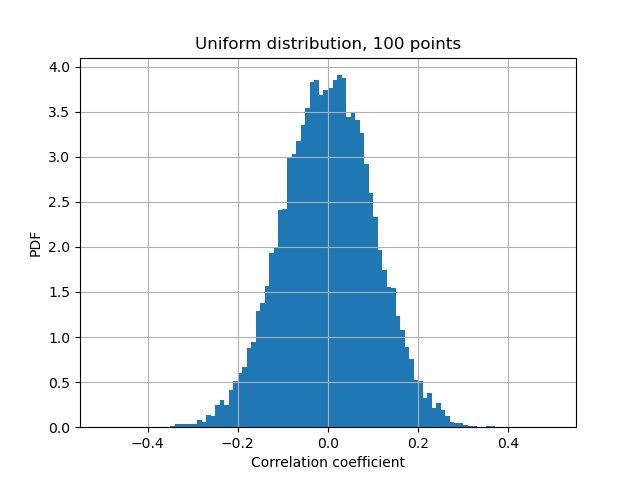

In [13]:
ntrials = 200
npts = 100

np.random.seed(1234)
y = np.random.rand(ntrials, npts)  # uniform distribution
ccoef = np.corrcoef(y)
print('The shape of y is %s, the shape of ccoef is %s.' 
      % (y.shape, ccoef.shape))

# we want all of the values except for the diagonal
di = np.diag_indices(ntrials)
ccoef = np.ma.asarray(ccoef)
ccoef[di] = np.ma.masked
ccoef_flat = ccoef.compressed()

fig, ax = plt.subplots()
ax.hist(ccoef_flat, bins=np.arange(-0.500, 0.5001, 0.01),
        density=True)
ax.grid(True)
ax.set_ylabel('PDF')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Uniform distribution, %d points' % npts);

In [6]:
plt.close(fig)

You can try the same thing with a normal distribution, or any other variation you like.  What happens if you use a small number of points in the series, say 10, instead of the larger number (100) in the example above?  Think about it, then experiment!

We can calculate the correlation coefficient using other functions:

In [31]:
x = np.random.rand(100)
y = np.random.rand(100)

# With correlate:
# We must remove the means.
cc1 = np.correlate(x - x.mean(), y - y.mean())[0]
# And we must normalize by the number of points
# and the product of the standard deviations.
cc1 /= (len(x) * x.std() * y.std())

# with corrcoef:
cc2 = np.corrcoef(x, y)[0, 1] # returns the 2x2 matric =>  0,1 selects the off-diagnol

print(cc1, cc2)

# np.corrcoef?

-0.027827597971226907 -0.027827597971226872


Notice that the `correlate` function is just returning a *sum of products*.

The `correlate` function is more general, however; with the `mode='full'` kwarg, it is useful for calculating the correlation as a function of lag.  Start with autocorrelation. Note that zero-padding is used, so that the estimated sample correlation at a given lag is the sum of the overlapping products.  To get an estimate of the autocorrelation function, we normalize by the value at zero-lag.  The zero-padding builds in a taper towards zero at maximum magnitude of the lag.  Hence it is a biased estimator, but one with reduced mean squared error compared to an unbiased estimator.

<IPython.core.display.Javascript object>


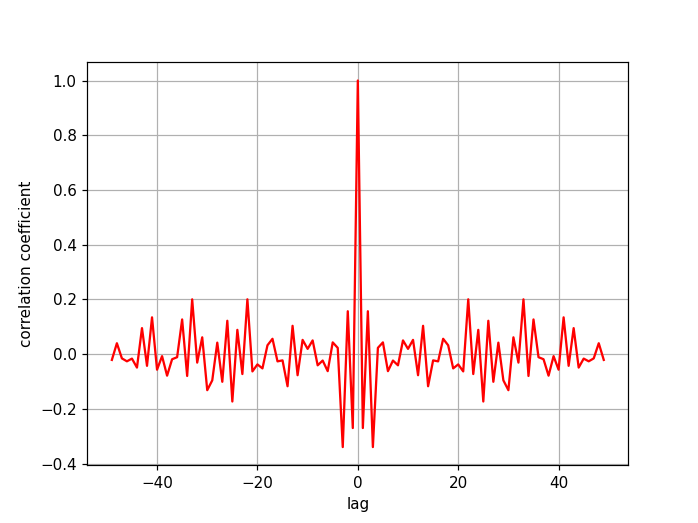

In [47]:
nx = 50
x = np.random.rand(nx) # normal RV

lags = np.arange(-nx + 1, nx) # so last value is nx - 1

# Remove sample mean.
xdm = x - x.mean()

autocorr_xdm = np.correlate(xdm, xdm, mode='full')

# Normalize by the zero-lag value:
autocorr_xdm /= autocorr_xdm[nx - 1]

fig, ax = plt.subplots()
ax.plot(lags, autocorr_xdm, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)

In [ ]:
plt.close(fig)

Notice that in the example above, removing the sample mean has very little effect, because the sample mean is nearly zero.  With typical data sets, this will not be the case. In general you *should* remove the sample mean before estimating the autocorrelation--and the `correlate` function does not do this for you. 



Exercise: illustrate this by executing the above cell with `randn` changed to `rand`.



Exercise: execute the cell multiple times, noting that the plot changes each time, because each call to `randn` yields a different set of numbers.  The true autocorrelation is zero at all non-zero lags, but the *sample* autocorrelation estimate is not zero.



Exercise: execute the above cell with different values of nx.

## Sequentially correlated data: equivalent degrees of freedom (EDOF)

First, let's make a function to calculate the estimated autocorrelation, so we don't have to keep typing in the same steps:

In [48]:
def autocorr(x, twosided=False, tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    nx = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    ac /= ac[nx - 1]
    lags = np.arange(-nx + 1, nx)
    if not tapered:  # undo the built-in taper
        taper = 1 - np.abs(lags) / float(nx)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[nx-1:], ac[nx-1:]

Now, we also need a function for estimating the equivalent number of degrees of freedom (EDOF) for the standard error of the mean.  Note that the EDOF is itself just an uncertain estimate, specific to a particular statistic (here, to the SEM), and with no one perfect estimator.

Let's just make a single function that returns the mean, the SEM, and the EDOF used to estimate the SEM.

In [50]:
def mean_sem_edof(y, truncated=True, tapered_cor=True):
    """
    Return the mean, SEM, and EDOF for the sequence y.

    If truncated is True (default), the EDOF and SEM will
    be calculated based on only the positive central peak of
    the sample autocorrelation.

    If tapered_cor is True (default), the low-MSE estimate of
    the lagged correlation is used.
    """
    ym = y.mean()
    n = len(y)
    lags, ac = autocorr(y, twosided=True, tapered=tapered_cor)
    taper = 1 - np.abs(lags) / n
    if truncated:
        i1 = np.nonzero(np.logical_and(lags >= 0, ac < 0))[0].min()
        i0 = 2 * n - i1 - 1  # taking advantage of symmetry...
        sl = slice(i0, i1)
    else:
        sl = slice(None)
    edof = n / np.sum(taper[sl] * ac[sl])
    with np.errstate(invalid='ignore'):
        sem = y.std() / np.sqrt(edof)
    return ym, sem, edof

If we take a set of uncorrelated points and apply a smoothing operator, the output will be sequentially correlated. This is illustrated below with a 5-point boxcar filter, implemented using the `convolve` function.

<IPython.core.display.Javascript object>


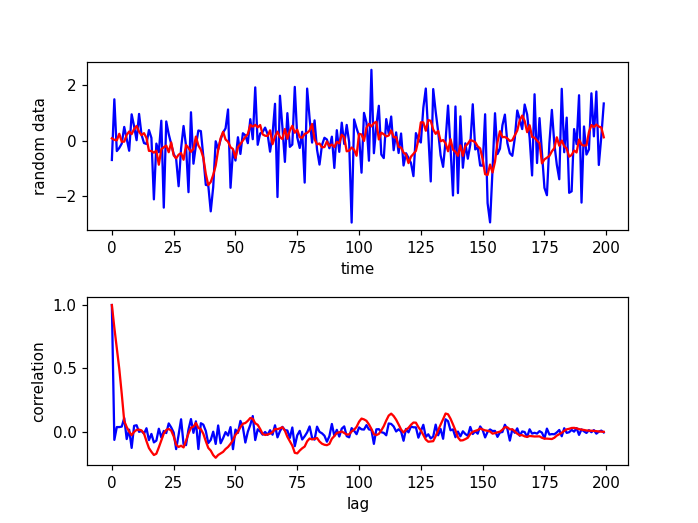

In [62]:
nx = 200
t = np.arange(nx)
x = np.random.randn(nx)
rmw=5 # running-mean window
xc = np.convolve(x, np.ones(rmw) / rmw, mode='same')

fig, (ax0, ax1) = plt.subplots(2)
fig.subplots_adjust(hspace=0.4)
ax0.plot(t, x, 'b', t, xc, 'r')
ax0.set_xlabel('time')
ax0.set_ylabel('random data')

lags, auto_x = autocorr(x)
lags, auto_xc = autocorr(xc)
ax1.plot(lags, auto_x, 'b', lags, auto_xc, 'r')
ax1.set_xlabel('lag')
ax1.set_ylabel('correlation')

for ax in (ax0, ax1):
    ax.locator_params(axis='y', nbins=4)


In [ ]:
plt.close(fig)

Notice how smoothing a series of independent random numbers has yielded a slowly-varying time series, and an estimated autocorrelation function with a wider central lobe and larger values in the side lobes where the *true* autocorrelation is zero; values separated by more than the width of the smoothing window are actually still statistically independent, but this is not clear based on the *sample* autocorrelation.



Exercise: use simple statistical concepts to explain *why* we see these *larger* sidelobes.



Exercise: calculate mean, SEM, and EDOF for many realizations, and quantify how well or how badly this estimate of SEM matches the actual statistics of the mean. 

In [ ]:
for truncated in (True, False):
    print("Integrating over central peak? ", truncated)
    for tapered_cor in (True, False):
        print("  Tapered correlation estimate? ", tapered_cor)
        print("    x:  %7.3f  %7.3f  %9.1f " % 
              mean_sem_edof(x, truncated=truncated, tapered_cor=tapered_cor))
        print("    xc: %7.3f  %7.3f  %9.1f " % 
              mean_sem_edof(xc, truncated=truncated, tapered_cor=tapered_cor)) 
        print("")

Note that integrating over the whole lagged autocorrelation function fails if the tapered estimator is not used, and is wildly inaccurate even when the tapered estimator is used.

## Cross correlation

What one sees most often in data analysis papers is not the autocorrelation, but the cross correlation between two time series, or between a single time series, such as the Southern Oscillation Index (SOI) and the time series at each of many locations, such as SST on a 1-degree grid.  Such cross correlations can be at zero lag, or as a function of lag.  The calculation is straightforward; the main point of confusion is the definition of the lag.  Let's experiment with two time series, each with a sinusoid plus some noise.  The first, `y1`, reaches its maximum value 1/4 cycle *after* the second one, `y2`.  Therefore `y1` *lags* `y2`, or `y2` *leads* `y1`.  Unfortunately, there is no single convention for defining the cross-covariance or cross-correlation; Jenkins and Watts (1968) use one convention, and Emery and Thompson (2001) use the opposite.  The `np.correlate()` function matches Emery and Thompson; we will use that one.

<IPython.core.display.Javascript object>


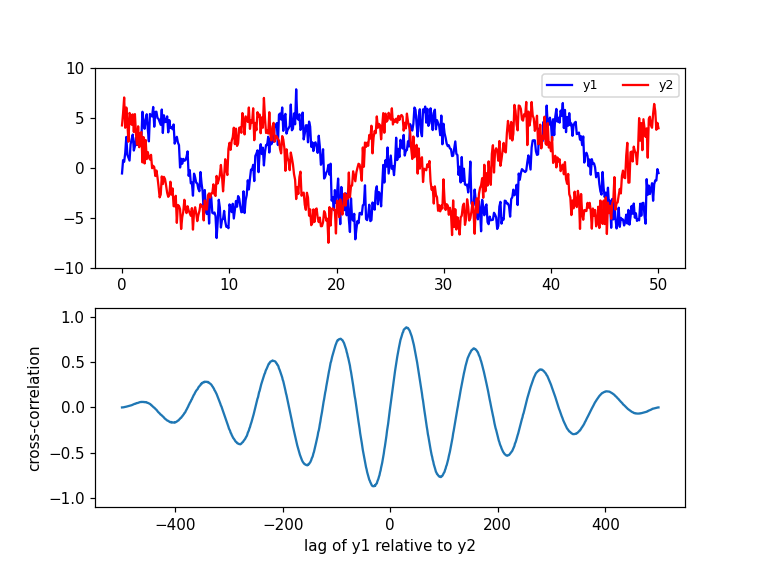

max correlation is at lag 30
0.8824871826126488


In [66]:
npts = 500
x = np.linspace(0, 50, npts)
y1 = 5 * np.sin(x/2) + np.random.randn(npts)
y2 = 5 * np.cos(x/2) + np.random.randn(npts)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
# fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
ax.set_ylim(-10, 10)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)
print(np.max(ccor))

In [ ]:
plt.close(fig)

This can all get quite confusing.  The red curve, `y2`, peaks to the *left* of `y1`.  Doesn't that mean it *lags* `y1`?  No, it *leads*.  Think of yourself moving forward in time, to the right along the x-axis.  As you slide along, you see the red curve peak *before* the blue.

To summarize: with the calculation done as above, a positive lag means the first series lags the second, or the second leads the first--peaks earlier in time, so at a location to the left on the time series plot.

You will also have noticed that this estimator of the cross-correlation decays to zero at the ends.  This is a biased estimator.  We could remove that bias by normalizing by the number of points going into the sum instead of by the total number of points.  In practice it usually doesn't matter.  To get a reliable lagged correlation, one needs a large number of points, and usually the only lags of interest are a small fraction of the total number of points.

## Irregular sampling and interpolation

Estimation of statistical constructs such as the lagged autocorrelation function are vastly simpler when the data are uniformly spaced.  When real data are not uniformly sampled, we often use the expedient of interpolation to put them on a uniform grid for analysis.  The simplest method, linear interpolation, is usually good enough; and a general principle of data analysis is, "use the simplest technique that will reveal the signal of interest".  (Actually, there is a simpler method than linear interpolation.  If the sampling is only slightly non-uniform, so that sample times are close to regular grid points, then nearest-neighbor interpolation to the uniform grid can be superior to interpolation.)



Here, we will make a quite irregular set of fake sample times by summing uniformly distributed random values.

standard deviations:  1.021593204641403 0.7852041268794747


<IPython.core.display.Javascript object>


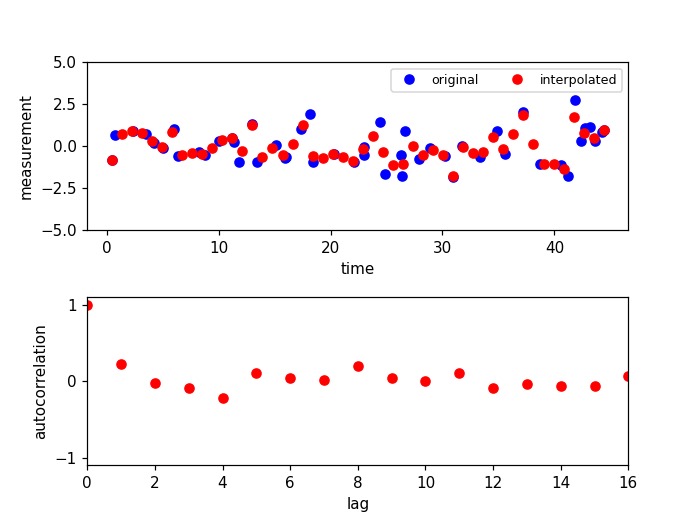

Text(0, 0.5, 'autocorrelation')

In [67]:
nt = 50
t = 2 * np.random.rand(50).cumsum()
x = np.random.randn(nt)

# Make a uniform grid, with the same number of points:
tnew = np.linspace(t.min(), t.max(), nt)
xnew = np.interp(tnew, t, x)

print("standard deviations: ", x.std(), xnew.std())

fig, (ax0, ax1) = plt.subplots(2)
fig.subplots_adjust(hspace=0.4)
ax0.plot(t, x, 'bo', label='original') 
ax0.plot(tnew, xnew, 'ro', label='interpolated')
ax0.set_xlabel('time')
ax0.set_ylabel('measurement')
ax0.legend(loc='upper right', ncol=2, fontsize='small')
ax0.set_ylim(-5, 5)

lags, auto_x = autocorr(xnew)
ax1.plot(lags, auto_x, 'ro')

for ax in (ax0, ax1):
    ax.locator_params(axis='y', nbins=4)

ax1.set_xlim(0, nt//3) # To see the smaller lags better.
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel('lag')
ax1.set_ylabel('autocorrelation')

In [ ]:
plt.close(fig)

Notice how the interpolation has reduced the standard deviation.

### Interpolating gaps

Often observations are taken at uniform intervals, but there are gaps because something went wrong. We will illustrate with a fake time series consisting of a sinusoid plus noise.

<IPython.core.display.Javascript object>


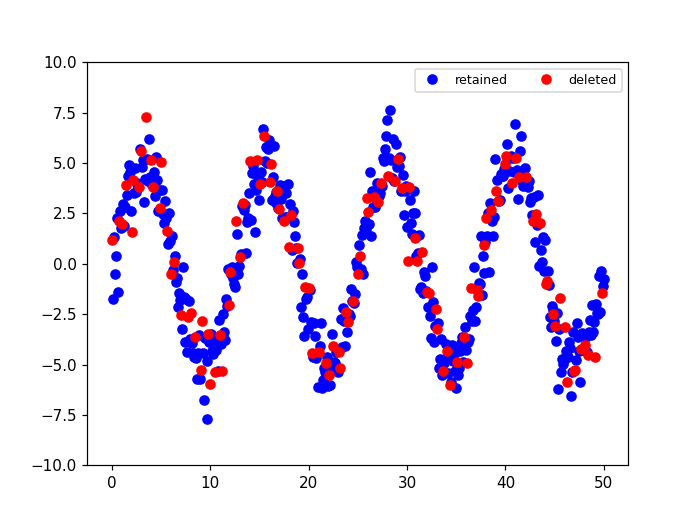

In [72]:
npts = 500
x = np.linspace(0, 50, npts)
y = 5 * np.sin(x/2) + np.random.randn(npts)
y_orig = y.copy() 

# Insert some nans:
y[::7] = np.nan
y[::10] = np.nan

ym = np.ma.masked_invalid(y)

fig, ax = plt.subplots()
ax.plot(x, ym, 'bo', label='retained')
ax.plot(x[ym.mask], y_orig[ym.mask], 'ro', label='deleted')
ax.set_ylim([-10, 10])
ax.legend(loc='upper right', fontsize='small', ncol=2)

In [ ]:
plt.close(fig)

Now interpolate.  We need to make x and y ndarrays with no gaps by removing the points where ym is masked.

In [73]:
xtab = np.ma.array(x, mask=ym.mask).compressed()
ytab = ym.compressed()

yfilled = ym.filled()   # no longer masked
yfilled[ym.mask] = np.interp(x[ym.mask], xtab, ytab)


<IPython.core.display.Javascript object>


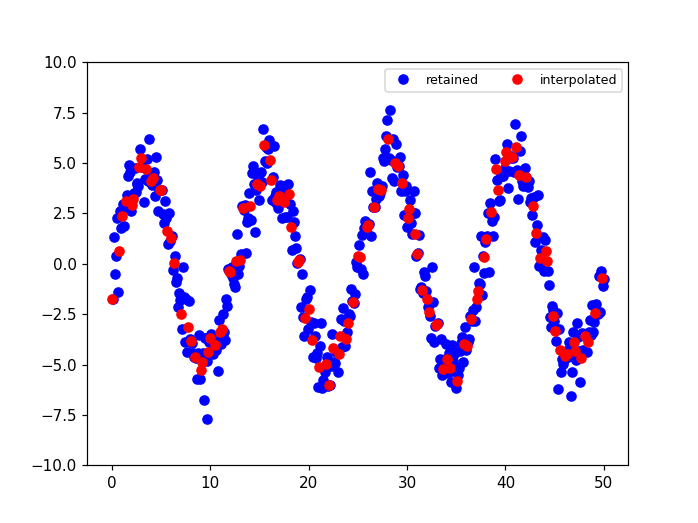

In [74]:
fig, ax = plt.subplots()
ax.plot(x, ym, 'bo', label='retained')
ax.plot(x[ym.mask], yfilled[ym.mask], 'ro', label='interpolated')
ax.set_ylim([-10, 10])
ax.legend(loc='upper right', fontsize='small', ncol=2)


In [ ]:
plt.close(fig)

I like using masked arrays, but of course we could easily do the same thing without detouring through ma:

In [75]:
mask = np.isnan(y)
yfilled2 = y.copy()
yfilled2[mask] = np.interp(x[mask], x[~mask], y[~mask])

identical = (yfilled2 == yfilled).all()
print("They are identical?", identical)

They are identical? True
